# Chapter 15: Comparing means

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, binom, scoreatpercentile, binomtest, f
import pingouin as pg
import matplotlib
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
# import NHANES package
base = importr('NHANES')
%load_ext rpy2.ipython

with localconverter(ro.default_converter + pandas2ri.converter):
  NHANES = ro.conversion.rpy2py(ro.r['NHANES'])

 
NHANES = NHANES.drop_duplicates(subset='ID').replace(-2147483648, np.nan)
NHANES_adult = NHANES.dropna(subset=['BPDiaAve']).query('Age > 17 and BPDiaAve > 0')

rng = np.random.default_rng(1234)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Binomial test for a single proportion

In [48]:
NHANES_adult['Hypertensive'] = NHANES_adult.BPDiaAve > 80

NHANES_sample = NHANES_adult.sample(200, random_state=rng)

# compute sign test for differences between first and second measurement
npos = NHANES_sample.Hypertensive.sum()

print(binomtest(npos, NHANES_sample.shape[0], alternative='greater'))

BinomTestResult(k=22, n=200, alternative='greater', proportion_estimate=0.11, pvalue=1.0)


## T-test output

In [49]:
pg.ttest(NHANES_sample.BPDiaAve, 80, alternative='greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-14.293279,199,greater,1.0,"[67.29, inf]",1.010687,3.983e-30,0.0


## Bayes factor output

In [50]:
%%R -i NHANES_sample
library(BayesFactor)
ttestBF(NHANES_sample$BPDiaAve, mu=80, nullInterval=c(-Inf, 80))

R[write to console]: t is large; approximation invoked.

R[write to console]: t is large; approximation invoked.



Bayes factor analysis
--------------
[1] Alt., r=0.707 -Inf<d<80    : 1.259034e+29 ±NA%
[2] Alt., r=0.707 !(-Inf<d<80) : NaNe-Inf     ±NA%

Against denominator:
  Null, mu = 80 
---
Bayes factor type: BFoneSample, JZS



## Figure 15.1

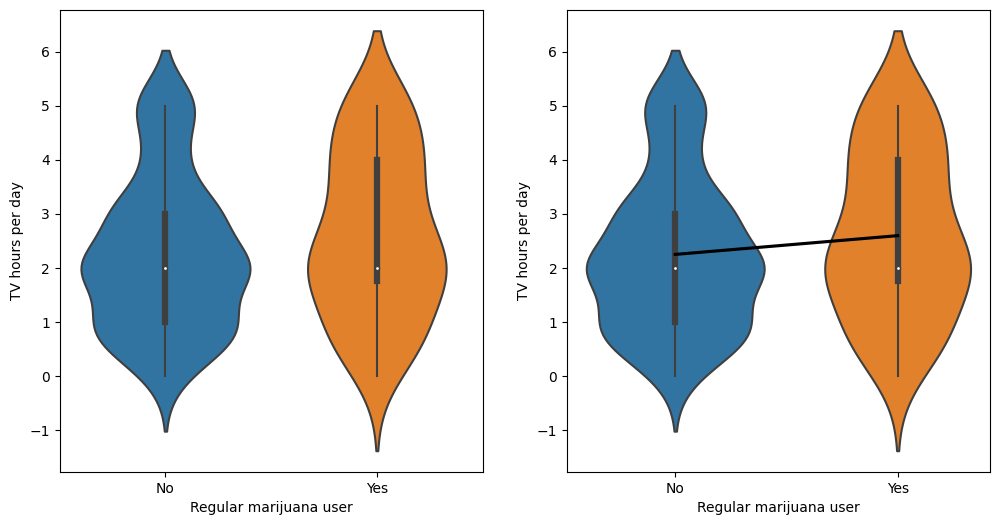

In [51]:
NHANES_sample = NHANES_adult.dropna(subset=['TVHrsDay', 'RegularMarij']).sample(200, random_state=rng)

tv_recoder = {
    "More_4_hr": 5,
    "4_hr": 4,
    "2_hr": 2,
    "1_hr": 1,
    "3_hr": 3,
    "0_to_1_hr": 0.5,
    "0_hrs": 0
}

NHANES_sample['TVHrsNum'] = [tv_recoder[i] for i in NHANES_sample.TVHrsDay]
NHANES_sample['RegularMarijNum'] = [1 if i == "Yes" else 0 for i in NHANES_sample['RegularMarij']]

fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.violinplot(data=NHANES_sample, x='RegularMarij', y='TVHrsNum', ax=ax[0])


sns.violinplot(data=NHANES_sample, x='RegularMarij', y='TVHrsNum', ax=ax[1])
sns.regplot(data=NHANES_sample, x='RegularMarijNum', y='TVHrsNum', ax=ax[1], 
            scatter=False, ci=None, color='black')

for x in range(2):
    ax[x].set_xlabel("Regular marijuana user")
    ax[x].set_ylabel("TV hours per day")


## T-test result

In [52]:
tt = pg.ttest(x=NHANES_sample.query('RegularMarij == "Yes"').TVHrsNum, 
              y=NHANES_sample.query('RegularMarij == "No"').TVHrsNum,
              alternative='greater', correction=False)
tt

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.470448,198,greater,0.071514,"[-0.04, inf]",0.243457,0.956,0.4288


## Linear model summary

In [53]:
# print summary of linear regression to perform t-test

lmresult = smf.ols(formula='TVHrsNum ~ RegularMarij', data=NHANES_sample).fit()

print(lmresult.summary())

                            OLS Regression Results                            
Dep. Variable:               TVHrsNum   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.162
Date:                Thu, 01 Sep 2022   Prob (F-statistic):              0.143
Time:                        11:59:45   Log-Likelihood:                -353.68
No. Observations:                 200   AIC:                             711.4
Df Residuals:                     198   BIC:                             718.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.2467    

## Bayes factor for mean differences

In [54]:
%%R -i NHANES_sample

# compute bayes factor for group comparison
# In this case, we want to specifically test against the null hypothesis that the difference is greater than zero - because the difference is computed by the function between the first group ('No') and the second group ('Yes'). Thus, we specify a "null interval" going from zero to infinity, which means that the alternative is less than zero.
bf <- ttestBF(
  formula = TVHrsNum ~ RegularMarij,
  data = NHANES_sample,
  nullInterval = c(0, Inf)
)
bf

Bayes factor analysis
--------------
[1] Alt., r=0.707 0<d<Inf    : 0.07678227 ±0%
[2] Alt., r=0.707 !(0<d<Inf) : 0.8795491  ±0%

Against denominator:
  Null, mu1-mu2 = 0 
---
Bayes factor type: BFindepSample, JZS



## Figure 15.2

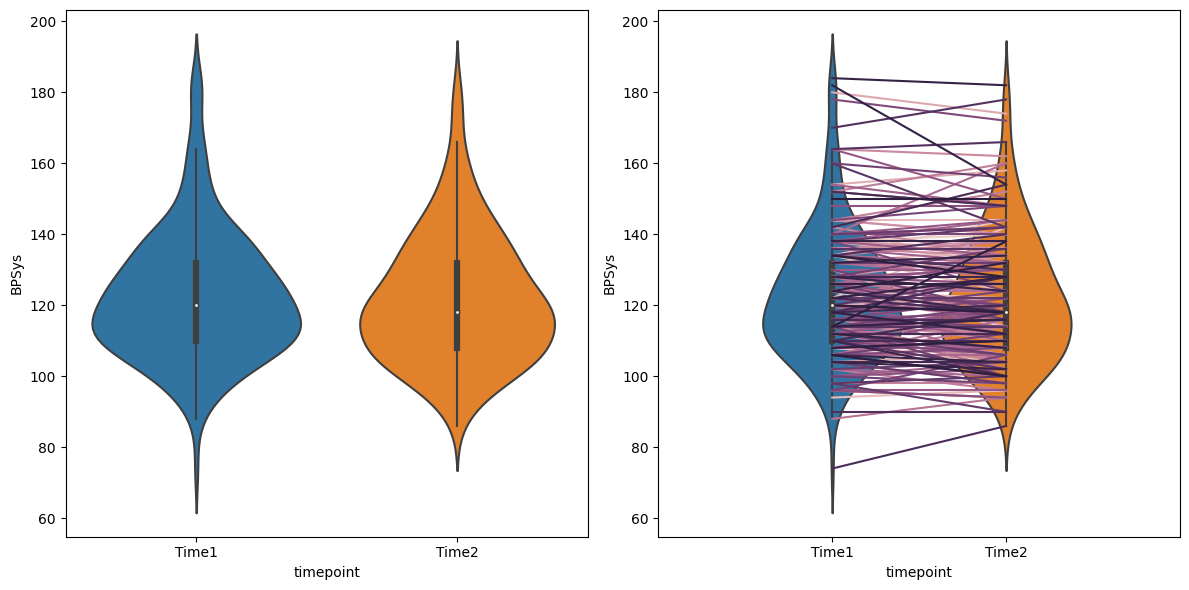

In [73]:
NHANES_sample = NHANES_adult.dropna(
    subset=['BPSys1', 'BPSys2']).sample(200, random_state=rng)[['ID', 'BPSys1', 'BPSys2']]
NHANES_sample_long = pd.melt(NHANES_sample, id_vars='ID', var_name='timepoint', value_name='BPSys')
NHANES_sample_long.timepoint = NHANES_sample_long.timepoint.replace({'BPSys1': 'Time1', 'BPSys2': 'Time2'})
fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.violinplot(data=NHANES_sample_long, x='timepoint', y='BPSys', ax=ax[0])

sns.violinplot(data=NHANES_sample_long, x='timepoint', y='BPSys', ax=ax[1])
sns.lineplot(data=NHANES_sample_long, x='timepoint', y='BPSys', hue='ID',
             ax=ax[1], color='black', legend=False)
ax[1].set_xlim((-1, 2))
ax[1].set_ylim(ax[0].get_ylim())
plt.tight_layout()

## T-test output

In [74]:
tt = pg.ttest(x=NHANES_sample_long.query('timepoint == "Time1"').BPSys, 
              y=NHANES_sample_long.query('timepoint == "Time2"').BPSys,
              alternative='greater', correction=False)
tt

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.466004,398,greater,0.320734,"[-2.13, inf]",0.0466,0.246,0.119072


## Figure 15.3

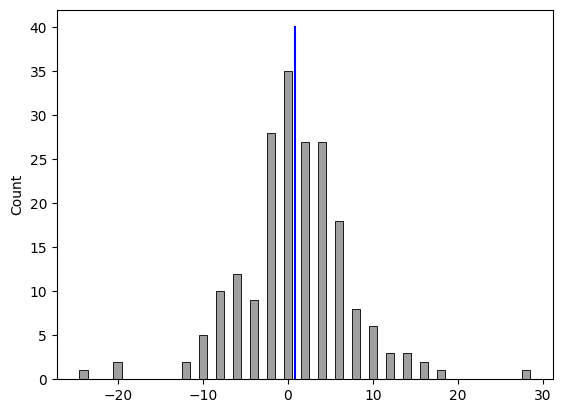

In [79]:
NHANES_sample.diff = NHANES_sample.BPSys1 - NHANES_sample.BPSys2

sns.histplot(NHANES_sample.diff, bins=30, discrete=True, color='gray')
plt.plot([NHANES_sample.diff.mean()] * 2, [0, 40], color='blue')

## Sign test


In [91]:
# compute sign test for differences between first and second measurement
npos = sum(NHANES_sample.diff > 0)
binomtest(npos, NHANES_sample.shape[0], .5)


BinomTestResult(k=96, n=200, alternative='two-sided', proportion_estimate=0.48, pvalue=0.6207289280968307)

## Paired t-test


In [82]:
ttpaired = pg.ttest(x=NHANES_sample.BPSys1, 
              y=NHANES_sample.BPSys2, paired=True,
              alternative='greater', correction=False)
ttpaired

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.840435,199,greater,0.033597,"[0.09, inf]",0.0466,0.828,0.161561


## Bayes factor result

In [94]:
%%R -i NHANES_sample

# compute Bayes factor for paired t-test
ttestBF(x = NHANES_sample$BPSys1, y = NHANES_sample$BPSys2,  paired = TRUE)

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 0.4138236 ±0.05%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS



## Figure 15.4

Text(0, 0.5, 'systolic blood pressure')

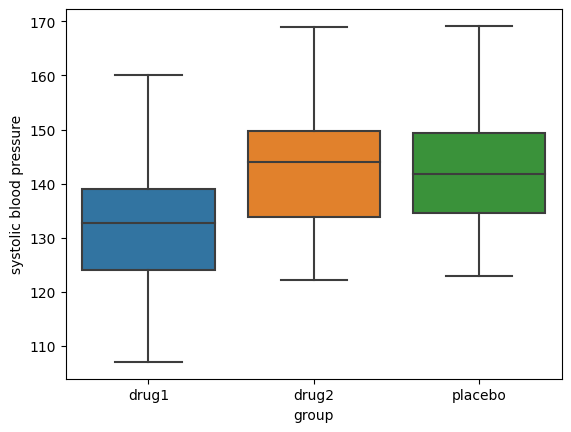

In [117]:
nPerGroup = 36
noiseSD = 10
meanSysBP = 140
effectSize = 0.8
DrugDf = pd.DataFrame({'group': ['drug1', 'drug2', 'placebo'] * nPerGroup})

DrugDf['SysBP'] = rng.normal(loc=meanSysBP, scale=noiseSD, size=DrugDf.shape[0]) - (DrugDf.group == 'drug1') * effectSize * noiseSD

sns.boxplot(data=DrugDf, x='group', y='SysBP')
plt.ylabel('systolic blood pressure')

## Figure 15.5

Text(0, 0.5, 'density')

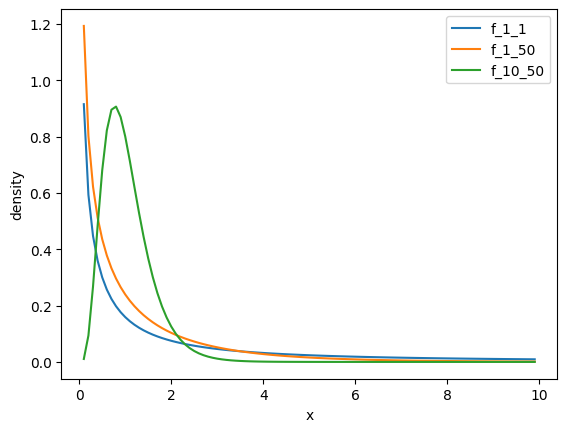

In [112]:
fdata = pd.DataFrame({'x': np.arange(0.1, 10, .1)})
df = [[1, 1], [1, 50], [10, 50]]
labels = []
for df1, df2 in df:
    label = f'f_{df1}_{df2}'
    fdata[label] = f.pdf(fdata.x, df1, df2)
    sns.lineplot(data=fdata, x='x', y=label, palette='colorblind')
    labels.append(label)

plt.legend(labels)
plt.ylabel('density')

## ANOVA result

Statsmodels automatically generates dummy variables when it sees that an independent variable is categorical.

In [119]:
lmresultAnovaBasic = smf.ols(formula='SysBP ~ group', data=DrugDf).fit()

print(lmresultAnovaBasic.summary())

                            OLS Regression Results                            
Dep. Variable:                  SysBP   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     10.07
Date:                Thu, 01 Sep 2022   Prob (F-statistic):           0.000100
Time:                        12:52:54   Log-Likelihood:                -413.59
No. Observations:                 108   AIC:                             833.2
Df Residuals:                     105   BIC:                             841.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          131.9393      1.883  